# Weather Informed Reservoir Operation

ResOpsUSData

- URL: https://zenodo.org/record/6612040
- Window: Daily records from 01-01-2008 to 12-31-2018 
- Steyaert, J.C., Condon, L.E., W.D. Turner, S. et al. ResOpsUS, a dataset of historical reservoir operations in the contiguous United States. Sci Data 9, 34 (2022). https://doi.org/10.1038/s41597-022-01134-7

California Data Exchange Center: California Department of Water Resources

- URL: https://cdec.water.ca.gov/dynamicapp/wsSensorData 
- Window: Daily and hourly records from 01-01-2008 to 12-31-2018 

In [21]:
import warnings
warnings.simplefilter("ignore")

from datetime import datetime, date
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style="white")
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

In [22]:
PROJECT_PATH = '/Users/alex791/Library/CloudStorage/OneDrive-PNNL/Documents/Projects/ML_Earth_Projects/Reservoir_Project'

### Loading ResOps data 

In [23]:
# from time_series_single_variable_table

daily_inflow = pd.read_csv(f'{PROJECT_PATH}/ResOpsUS/time_series_single_variable_table/DAILY_AV_INFLOW_CUMECS.csv')

In [24]:
daily_inflow.head()

,date,100,1000,1001,1002,1003,1005,1006,1007,101,...,981,982,983,987,989,99,991,993,995,998
0,1980-01-01,NaN,NaN,1.416,NaN,1.699,NaN,9.911,1.416,NaN,...,NaN,0.142,NaN,NaN,22.653,NaN,NaN,NaN,NaN,NaN
1,1980-01-02,NaN,NaN,1.416,NaN,1.699,NaN,8.495,1.416,NaN,...,NaN,0.142,NaN,NaN,22.653,NaN,NaN,NaN,NaN,NaN
2,1980-01-03,NaN,NaN,1.416,NaN,1.416,NaN,8.495,1.416,NaN,...,NaN,0.142,NaN,NaN,24.069,NaN,NaN,NaN,NaN,NaN
3,1980-01-04,NaN,NaN,1.416,NaN,0.850,NaN,7.079,0.850,NaN,...,NaN,0.142,NaN,NaN,24.069,NaN,NaN,NaN,NaN,NaN
4,1980-01-05,NaN,NaN,1.416,NaN,0.850,NaN,5.663,0.850,NaN,...,NaN,0.142,NaN,NaN,19.822,NaN,NaN,NaN,NaN,NaN


In [25]:
daily_inflow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14994 entries, 0 to 14993
Columns: 679 entries, date to 998
dtypes: float64(678), object(1)
memory usage: 77.7+ MB


In [26]:
# from attributes

time_series_inventory = pd.read_csv(f'{PROJECT_PATH}/ResOpsUS/attributes/time_series_inventory.csv')
time_series_inventory_variables = pd.read_csv(f'{PROJECT_PATH}/ResOpsUS/attributes/time_series_inventory_variables.csv')
time_series_variables = pd.read_csv(f'{PROJECT_PATH}/ResOpsUS/attributes/time_series_variables.csv')

reservoir_attributes = pd.read_csv(f'{PROJECT_PATH}/ResOpsUS/attributes/reservoir_attributes.csv')
reservoir_attributes_variables = pd.read_csv(f'{PROJECT_PATH}/ResOpsUS/attributes/reservoir_attributes_variables.csv')

agency_attributes = pd.read_csv(f'{PROJECT_PATH}/ResOpsUS/attributes/agency_attributes.csv')
agency_attributes_variables = pd.read_csv(f'{PROJECT_PATH}/ResOpsUS/attributes/agency_attributes_variables.csv')

In [27]:
time_series_inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678 entries, 0 to 677
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   DAM_ID             678 non-null    int64 
 1   STORAGE            678 non-null    int64 
 2   STORAGE_START      653 non-null    object
 3   STORAGE_END        653 non-null    object
 4   DATA_SOURCE        653 non-null    object
 5   INFLOW             678 non-null    int64 
 6   INFLOW_START       316 non-null    object
 7   INFLOW_END         316 non-null    object
 8   DATA_SOURCE.1      332 non-null    object
 9   OUTFLOW            678 non-null    int64 
 10  OUTFLOW_START      518 non-null    object
 11  OUTFLOW_END        518 non-null    object
 12  DATA_SOURCE.2      555 non-null    object
 13  ELEVATION          678 non-null    int64 
 14  ELEVATION_START    506 non-null    object
 15  ELEVATION_END      506 non-null    object
 16  DATA_SOURCE.3      553 non-null    object
 1

In [28]:
time_series_inventory.head()

,DAM_ID,STORAGE,STORAGE_START,STORAGE_END,DATA_SOURCE,INFLOW,INFLOW_START,INFLOW_END,DATA_SOURCE.1,OUTFLOW,...,OUTFLOW_END,DATA_SOURCE.2,ELEVATION,ELEVATION_START,ELEVATION_END,DATA_SOURCE.3,EVAPORATION,EVAPORATION_START,EVAPORATION_END,DATA_SOURCE.4
0,41,1,10/1/70,8/31/20,SCL,1,10/1/70,8/31/20,SCL,1,...,8/31/20,SCL,1,10/1/70,8/31/20,SCL,0,NaN,NaN,NaN
1,42,1,10/1/70,8/31/20,SCL,1,10/1/70,8/31/20,SCL,1,...,8/31/20,SCL,1,10/1/70,8/31/20,SCL,0,NaN,NaN,NaN
2,54,1,10/1/15,12/31/20,BOR_PN,0,NaN,NaN,NaN,1,...,12/31/20,BOR_PN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
3,55,1,1/1/65,12/31/20,BOR_PN,1,1/1/65,12/31/20,BOR_PN,1,...,12/31/20,BOR_PN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
4,56,1,1/1/90,12/31/20,ACE_SEA,0,NaN,NaN,NaN,1,...,12/31/20,usgs_12105900,1,1/1/90,12/31/20,ACE_SEA,0,NaN,NaN,NaN


In [29]:
time_series_inventory_variables

,Variable,Meaning
0,DAM_ID,ID for the dam which can be linked to time ser...
1,STORAGE,Binary to depict if data exists for this varia...
2,STORAGE_START,Earliest date that there is storage data for t...
3,STORAGE_END,Last date that there is storage data for this ...
4,DATA_SOURCE,The data source of this variable. Note that da...
5,INFLOW,Binary to depict if data exists for this varia...
6,INFLOW_START,Earliest date that there is inflow data for th...
7,INFLOW_END,Last date that there is inflow data for this d...
8,OUTFLOW,Earliest date that there is outflow data for t...
9,OUTFLOW_END,Last date that there is outflow data for this ...


In [30]:
time_series_variables

,Variable,Unit,Unit Text,Time Period,Parameter
0,IN,ms,cubic meters per second,Daily,Reservoir Inflow
1,STOR,MCM,Million Cubic Meters,Daily,Reservoir Storage
2,ELE,m,meters,Daily,Reservoir Elevation
3,OUT,ms,cubic meters per second,Daily,Reservoir Outflow
4,EVAP,MCM,million cubic meters,Daily,Reservoir Evaporation


In [31]:
reservoir_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678 entries, 0 to 677
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DAM_ID                 678 non-null    int64  
 1   DAM_NAME               678 non-null    object 
 2   STATE                  678 non-null    object 
 3   AGENCY_CODE            678 non-null    object 
 4   LONG                   678 non-null    float64
 5   LAT                    678 non-null    float64
 6   TIME_SERIES_START      678 non-null    object 
 7   TIME_SERIES_END        677 non-null    object 
 8   INCONSISTENCIES_NOTED  3 non-null      object 
dtypes: float64(2), int64(1), object(6)
memory usage: 47.8+ KB


In [32]:
reservoir_attributes.head()

,DAM_ID,DAM_NAME,STATE,AGENCY_CODE,LONG,LAT,TIME_SERIES_START,TIME_SERIES_END,INCONSISTENCIES_NOTED
0,41,Ross,Washington,SCL,-121.067305,48.732466,10/1/70,8/31/20,NaN
1,42,Diablo,Washington,SCL,-121.130320,48.714583,10/1/70,8/31/20,NaN
2,54,Wynoochee,Washington,USGS,-123.604561,47.386357,1/1/80,12/31/20,NaN
3,55,Keechelus,Washington,BOR_PN,-121.340171,47.323654,1/1/65,12/31/20,NaN
4,56,Howard A. Hanson Dam,Washington,ACE_SEA,-121.783969,47.277406,1/1/80,12/31/20,NaN


In [33]:
reservoir_attributes_variables.head()

,Variable,Meaning
0,DAM_ID,Unique DAM_ID for each dam that links reservoi...
1,DAM_NAME,Name of the dam that corresponds to the GRAND_...
2,STATE,State where the dam is located.
3,LONG,The longitude of the dam's location.
4,LAT,The latitude of the dam's location.


In [34]:
agency_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Agency_Code            47 non-null     object
 1   Agency_Name            47 non-null     object
 2   Data_Disclaimers       8 non-null      object
 3   Inflow/Outflow         44 non-null     object
 4   Additional_Data_Notes  16 non-null     object
 5   Access_ Date           46 non-null     object
 6   Access_Type            46 non-null     object
dtypes: object(7)
memory usage: 2.7+ KB


In [35]:
agency_attributes.head()

,Agency_Code,Agency_Name,Data_Disclaimers,Inflow/Outflow,Additional_Data_Notes,Access_ Date,Access_Type
0,BOR,Bureau of Reclamation,NaN,Real time,NaN,Spring 2020 - Fall 2020,website download: https://www.usbr.gov/rsvrWat...
1,ACE_LOU,Army Corps of Engineers- Louisville District,Disclaimer: Data may not be 100% accurate,Aggregated spatially and temporally,Given inflow and outflow from multiple sources...,Spring 2020,personal communication
2,ACE_SAC,Army Corps of Engineers-Sacramento District,NaN,NaN,NaN,Spring 2021,website download:https://nicholasinstitute.duk...
3,ACE_OMA,Army Corps of Engineers-Omaha District,NaN,NaN,NaN,Summer 2020,personal communication
4,ACE_STP,Army Corps of Engineers-St. Paul District,All data contained herein is preliminary in na...,NaN,NaN,NaN,NaN


In [36]:
agency_attributes_variables

,Variable,Meaning
0,Agency_Code,Unique code for each agency which can be trace...
1,Agency_Name,"Agency name and, where applicable, district na..."
2,Data_Disclaimers,Disclaimers on data use provided directly by t...
3,Inflow/Outflow,This columns tells if inflow and/or outflow we...
4,Additional_Data_Notes,Any additional notes for the processing or the...
5,Acces_ Date,Date when the data was last accessed.
6,Access_Type,Personal communication denotes that the data c...


### Selecting inflow data

In [37]:
# start with California dataset

ca_reservoirs = reservoir_attributes.loc[reservoir_attributes["STATE"] == "California", ["DAM_ID", "DAM_NAME", "AGENCY_CODE", "LAT", "TIME_SERIES_START", "TIME_SERIES_END"]]

In [38]:
ca_reservoirs[ca_reservoirs["DAM_NAME"] == "Folsom"]

,DAM_ID,DAM_NAME,AGENCY_CODE,LAT,TIME_SERIES_START,TIME_SERIES_END
76,182,Folsom,BOR,38.710426,3/1/55,12/18/18


In [39]:
folsom_inventory = time_series_inventory[time_series_inventory["DAM_ID"] == 182]

folsom_inventory_outflow_start = folsom_inventory.loc[:, ['DAM_ID', 'INFLOW_START', 'INFLOW_END']]
folsom_inventory_outflow_start

,DAM_ID,INFLOW_START,INFLOW_END
76,182,3/1/55,12/31/20


In [40]:
"""
INFLOW_START: 3/1/55
INFLOW_END: 12/31/20
"""

folsom_daily_inflow = daily_inflow.loc[:, ['date', '182']]
folsom_daily_inflow['date'] = folsom_daily_inflow['date'].map(lambda d: pd.Timestamp(d))

In [41]:
# index for 2008-1-1 is 10227 
# 182 is the dam ID 

folsom_daily_inflow[folsom_daily_inflow["date"] == datetime(2008, 1, 1)]

,date,182
10227,2008-01-01,27.666


In [42]:
# index for 2018-12-31 is 14262

folsom_daily_inflow[folsom_daily_inflow["date"] == datetime(2018, 12, 31)]

,date,182
14262,2018-12-31,33.895


In [43]:
# 1/1/2008 - 12/31/18 is the inflow range for the reservoir to use 
# Using 20 years worth of data 

INFLOW_FROM_2008 = folsom_daily_inflow.iloc[10227:14263]
INFLOW_FROM_2008.reset_index(drop=True, inplace=True)
INFLOW_FROM_2008.rename(columns={"date": "OBS DATE", "182": "INFLOW"}, inplace=True)
INFLOW_FROM_2008.head()

,OBS DATE,INFLOW
0,2008-01-01,27.666
1,2008-01-02,30.044
2,2008-01-03,48.478
3,2008-01-04,90.246
4,2008-01-05,200.200


In [44]:
INFLOW_FROM_2008.tail()

,OBS DATE,INFLOW
4031,2018-12-27,58.559
4032,2018-12-28,46.808
4033,2018-12-29,45.250
4034,2018-12-30,42.985
4035,2018-12-31,33.895


In [45]:
INFLOW_FROM_2008.set_index('OBS DATE', inplace=True)

In [46]:
INFLOW_FROM_2008.head()

,INFLOW
OBS DATE,
2008-01-01,27.666
2008-01-02,30.044
2008-01-03,48.478
2008-01-04,90.246
2008-01-05,200.200


### Loading and selecting CDEC Water data 

In [47]:
# Prepare dataframes for merge

def prepare_station_df(station_data, hourly=False):
    date_type = str(station_data['OBS DATE'].dtype)
    # Convert observed dates to shared date format
    if (date_type == "int64" or date_type == "float64"):
      station_data['OBS DATE'] = pd.to_datetime(station_data['OBS DATE'], format='%Y%m%d')
    else: 
      station_data['OBS DATE'] = pd.to_datetime(station_data['OBS DATE']).dt.date
    
    # Set date as index
    if (hourly):
      station_data = station_data.groupby("OBS DATE").mean()
    else: 
      station_data.set_index('OBS DATE', inplace=True)

    # Create station df with observed value
    df = station_data[['VALUE']].copy()

    return df

#### Near American River, North Fork

In [48]:
### Auburn Dam Ridge (ADR) ###
# Elevation: 1,200 ft

# PRECIPITATION, ACCUMULATED, INCHES (daily)
ADR_PRECIP_ACC_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/ADR/ADR_2.xlsx')
ADR_PRECIP_ACC_DF = prepare_station_df(ADR_PRECIP_ACC_DATA)

# PRECIPITATION, INCREMENTAL, INCHES (daily)
# Incremental precipitation = difference between current and preceding accumulated precipitation
ADR_PRECIP_INCR_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/ADR/ADR_45.xlsx')
ADR_PRECIP_INCR_DF = prepare_station_df(ADR_PRECIP_INCR_DATA)

# TEMPERATURE, AIR AVERAGE, DEG F (daily)
ADR_TEMP_AVG_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/ADR/ADR_30.xlsx')
ADR_TEMP_AVG_DF = prepare_station_df(ADR_TEMP_AVG_DATA)

# TEMPERATURE, AIR MAXIMUM, DEG F (daily)
ADR_TEMP_MAX_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/ADR/ADR_31.xlsx')
ADR_TEMP_MAX_DF = prepare_station_df(ADR_TEMP_MAX_DATA)

# TEMPERATURE, AIR MINIMUM, DEG F (daily)
ADR_TEMP_MIN_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/ADR/ADR_32.xlsx')
ADR_TEMP_MIN_DF = prepare_station_df(ADR_TEMP_MIN_DATA)


In [49]:
ADR_TEMP_MIN_DF.head()

,VALUE
OBS DATE,
2008-01-01,34.0
2008-01-02,39.0
2008-01-03,38.0
2008-01-04,42.0
2008-01-05,37.0


In [50]:
# Reset value name for df merge

ADR_PRECIP_ACC_DF.rename(columns={"VALUE": "ADR_PRECIP_ACC"}, inplace=True)
ADR_PRECIP_INCR_DF.rename(columns={"VALUE": "ADR_PRECIP_INCR"}, inplace=True)
ADR_TEMP_AVG_DF.rename(columns={"VALUE": "ADR_TEMP_AVG"}, inplace=True)
ADR_TEMP_MAX_DF.rename(columns={"VALUE": "ADR_TEMP_MAX"}, inplace=True)
ADR_TEMP_MIN_DF.rename(columns={"VALUE": "ADR_TEMP_MIN"}, inplace=True)

In [51]:
ADR_TEMP_MIN_DF.head()

,ADR_TEMP_MIN
OBS DATE,
2008-01-01,34.0
2008-01-02,39.0
2008-01-03,38.0
2008-01-04,42.0
2008-01-05,37.0


In [52]:
### Huysink (HYS) ###
# Elevation: 6,600 ft

# PRECIPITATION, ACCUMULATED, INCHES (daily)
HYS_PRECIP_ACC_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/HYS/HYS_2.xlsx')
HYS_PRECIP_ACC_DF = prepare_station_df(HYS_PRECIP_ACC_DATA)

# PRECIPITATION, INCREMENTAL, INCHES (daily)
HYS_PRECIP_INCR_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/HYS/HYS_45.xlsx')
HYS_PRECIP_INCR_DF = prepare_station_df(HYS_PRECIP_INCR_DATA)

# SNOW DEPTH, INCHES (daily)
HYS_SNOW_DEPTH_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/HYS/HYS_18.xlsx')
HYS_SNOW_DEPTH_DF = prepare_station_df(HYS_SNOW_DEPTH_DATA)

# SNOW, WATER CONTENT, INCHES (daily)
HYS_SNOW_WATER_CONTENT_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/HYS/HYS_3.xlsx')
HYS_SNOW_WATER_CONTENT_DF = prepare_station_df(HYS_SNOW_WATER_CONTENT_DATA)

# TEMPERATURE, AIR AVERAGE, DEG F (daily)
HYS_TEMP_AVG_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/HYS/HYS_30.xlsx')
HYS_TEMP_AVG_DF = prepare_station_df(HYS_TEMP_AVG_DATA)

# TEMPERATURE, AIR MAXIMUM, DEG F (daily)
HYS_TEMP_MAX_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/HYS/HYS_31.xlsx')
HYS_TEMP_MAX_DF = prepare_station_df(HYS_TEMP_MAX_DATA)

# TEMPERATURE, AIR MINIMUM, DEG F (daily)
HYS_TEMP_MIN_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/HYS/HYS_32.xlsx')
HYS_TEMP_MIN_DF = prepare_station_df(HYS_TEMP_MIN_DATA)


In [53]:
# Reset value name for df merge

HYS_PRECIP_ACC_DF.rename(columns={"VALUE": "HYS_PRECIP_ACC"}, inplace=True)
HYS_PRECIP_INCR_DF.rename(columns={"VALUE": "HYS_PRECIP_INCR"}, inplace=True)
HYS_SNOW_DEPTH_DF.rename(columns={"VALUE": "HYS_SNOW_DEPTH"}, inplace=True)
HYS_SNOW_WATER_CONTENT_DF.rename(columns={"VALUE": "HYS_SNOW_WATER_CONTENT"}, inplace=True)
HYS_TEMP_AVG_DF.rename(columns={"VALUE": "HYS_TEMP_AVG"}, inplace=True)
HYS_TEMP_MAX_DF.rename(columns={"VALUE": "HYS_TEMP_MAX"}, inplace=True)
HYS_TEMP_MIN_DF.rename(columns={"VALUE": "HYS_TEMP_MIN"}, inplace=True)

In [54]:
HYS_SNOW_DEPTH_DF.info

<bound method DataFrame.info of             HYS_SNOW_DEPTH
OBS DATE                  
2008-01-01            38.0
2008-01-02            38.0
2008-01-03            39.0
2008-01-04            45.0
2008-01-05            58.0
...                    ...
NaT                    NaN
2018-12-28            25.0
2018-12-29            24.0
2018-12-30            24.0
2018-12-31            25.0

[4018 rows x 1 columns]>

In [55]:
HYS_SNOW_DEPTH_DF.tail()

,HYS_SNOW_DEPTH
OBS DATE,
NaT,NaN
2018-12-28,25.0
2018-12-29,24.0
2018-12-30,24.0
2018-12-31,25.0


#### Near American River, Middle Fork

In [56]:
### Duncan (DUN) ###
# Elevation: 7,100 ft

# PRECIPITATION, ACCUMULATED, INCHES (hourly)
DUN_PRECIP_ACC_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/DUN/DUN_2.xlsx')
DUN_PRECIP_ACC_DF = prepare_station_df(DUN_PRECIP_ACC_DATA, hourly=True)

# WIND, PEAK GUST, MPH (hourly)
DUN_WIND_GUST_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/DUN/DUN_77.xlsx')
DUN_WIND_GUST_DF = prepare_station_df(DUN_WIND_GUST_DATA, hourly=True)

# WIND, SPEED, MPH (hourly)
DUN_WIND_SPEED_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/DUN/DUN_9.xlsx')
DUN_WIND_SPEED_DF = prepare_station_df(DUN_WIND_SPEED_DATA, hourly=True)

# TEMPERATURE, AIR AVERAGE, DEG F (daily)
DUN_TEMP_AVG_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/DUN/DUN_30.xlsx')
DUN_TEMP_AVG_DF = prepare_station_df(DUN_TEMP_AVG_DATA)

# TEMPERATURE, AIR MAXIMUM, DEG F (daily)
DUN_TEMP_MAX_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/DUN/DUN_31.xlsx')
DUN_TEMP_MAX_DF = prepare_station_df(DUN_TEMP_MAX_DATA)

# TEMPERATURE, AIR MINIMUM, DEG F (daily)
DUN_TEMP_MIN_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/DUN/DUN_32.xlsx')
DUN_TEMP_MIN_DF = prepare_station_df(DUN_TEMP_MIN_DATA)


In [57]:
# Reset value name for df merge

DUN_PRECIP_ACC_DF.rename(columns={"VALUE": "DUN_PRECIP_ACC"}, inplace=True)
DUN_WIND_GUST_DF.rename(columns={"VALUE": "DUN_WIND_GUST"}, inplace=True)
DUN_WIND_SPEED_DF.rename(columns={"VALUE": "DUN_WIND_SPEED"}, inplace=True)
DUN_TEMP_AVG_DF.rename(columns={"VALUE": "DUN_TEMP_AVG"}, inplace=True)
DUN_TEMP_MAX_DF.rename(columns={"VALUE": "DUN_TEMP_MAX"}, inplace=True)
DUN_TEMP_MIN_DF.rename(columns={"VALUE": "DUN_TEMP_MIN"}, inplace=True)

In [58]:
DUN_TEMP_MIN_DF.head()

,DUN_TEMP_MIN
OBS DATE,
2008-01-01,39.0
2008-01-02,32.0
2008-01-03,26.0
2008-01-04,NaN
2008-01-05,NaN


In [59]:
### Sugar Pine (SGP) ###
# Elevation: 3,843 ft

# PRECIPITATION, ACCUMULATED, INCHES (daily)
SGP_PRECIP_ACC_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/SGP/SGP_2.xlsx')
SGP_PRECIP_ACC_DF = prepare_station_df(SGP_PRECIP_ACC_DATA)

# PRECIPITATION, INCREMENTAL, INCHES (daily)
SGP_PRECIP_INCR_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/SGP/SGP_45.xlsx')
SGP_PRECIP_INCR_DF = prepare_station_df(SGP_PRECIP_INCR_DATA)

# TEMPERATURE, AIR AVERAGE, DEG F (daily)
SGP_TEMP_AVG_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/SGP/SGP_30.xlsx')
SGP_TEMP_AVG_DF = prepare_station_df(SGP_TEMP_AVG_DATA)

# TEMPERATURE, AIR MAXIMUM, DEG F (daily)
SGP_TEMP_MAX_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/SGP/SGP_31.xlsx')
SGP_TEMP_MAX_DF = prepare_station_df(SGP_TEMP_MAX_DATA)

# TEMPERATURE, AIR MINIMUM, DEG F (daily)
SGP_TEMP_MIN_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/SGP/SGP_32.xlsx')
SGP_TEMP_MIN_DF = prepare_station_df(SGP_TEMP_MIN_DATA)


In [60]:
# Reset value name for df merge

SGP_PRECIP_ACC_DF.rename(columns={"VALUE": "SGP_PRECIP_ACC"}, inplace=True)
SGP_PRECIP_INCR_DF.rename(columns={"VALUE": "SGP_PRECIP_INCR"}, inplace=True)
SGP_TEMP_AVG_DF.rename(columns={"VALUE": "SGP_TEMP_AVG"}, inplace=True)
SGP_TEMP_MAX_DF.rename(columns={"VALUE": "SGP_TEMP_MAX"}, inplace=True)
SGP_TEMP_MIN_DF.rename(columns={"VALUE": "SGP_TEMP_MIN"}, inplace=True)

In [61]:
SGP_TEMP_MIN_DF.head()

,SGP_TEMP_MIN
OBS DATE,
2008-01-01,27.0
2008-01-02,27.0
2008-01-03,34.0
2008-01-04,32.0
2008-01-05,31.0


#### Near American River, South Fork

In [62]:
### Forni Ridge (FRN) ###
# Elevation: 7,600 ft

# PRECIPITATION, ACCUMULATED, INCHES (daily)
FRN_PRECIP_ACC_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/FRN/FRN_2.xlsx')
FRN_PRECIP_ACC_DF = prepare_station_df(FRN_PRECIP_ACC_DATA)

# PRECIPITATION, INCREMENTAL, INCHES (daily)
FRN_PRECIP_INCR_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/FRN/FRN_45.xlsx')
FRN_PRECIP_INCR_DF = prepare_station_df(FRN_PRECIP_INCR_DATA)

# SNOW DEPTH, INCHES (daily)
FRN_SNOW_DEPTH_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/FRN/FRN_18.xlsx')
FRN_SNOW_DEPTH_DF = prepare_station_df(FRN_SNOW_DEPTH_DATA)

# SNOW, WATER CONTENT, INCHES (daily)
FRN_SNOW_WATER_CONTENT_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/FRN/FRN_3.xlsx')
FRN_SNOW_WATER_CONTENT_DF = prepare_station_df(FRN_SNOW_WATER_CONTENT_DATA)

# TEMPERATURE, AIR AVERAGE, DEG F (daily)
FRN_TEMP_AVG_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/FRN/FRN_30.xlsx')
FRN_TEMP_AVG_DF = prepare_station_df(FRN_TEMP_AVG_DATA)

# TEMPERATURE, AIR MAXIMUM, DEG F (daily)
FRN_TEMP_MAX_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/FRN/FRN_31.xlsx')
FRN_TEMP_MAX_DF = prepare_station_df(FRN_TEMP_MAX_DATA)

# TEMPERATURE, AIR MINIMUM, DEG F (daily)
FRN_TEMP_MIN_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/FRN/FRN_32.xlsx')
FRN_TEMP_MIN_DF = prepare_station_df(FRN_TEMP_MIN_DATA)


In [63]:
# Reset value name for df merge

FRN_PRECIP_ACC_DF.rename(columns={"VALUE": "FRN_PRECIP_ACC"}, inplace=True)
FRN_PRECIP_INCR_DF.rename(columns={"VALUE": "FRN_PRECIP_INCR"}, inplace=True)
FRN_SNOW_DEPTH_DF.rename(columns={"VALUE": "FRN_SNOW_DEPTH"}, inplace=True)
FRN_SNOW_WATER_CONTENT_DF.rename(columns={"VALUE": "FRN_SNOW_WATER_CONTENT"}, inplace=True)
FRN_TEMP_AVG_DF.rename(columns={"VALUE": "FRN_TEMP_AVG"}, inplace=True)
FRN_TEMP_MAX_DF.rename(columns={"VALUE": "FRN_TEMP_MAX"}, inplace=True)
FRN_TEMP_MIN_DF.rename(columns={"VALUE": "FRN_TEMP_MIN"}, inplace=True)

In [64]:
FRN_TEMP_MIN_DF.head()

,FRN_TEMP_MIN
OBS DATE,
2008-01-01,37.0
2008-01-02,32.0
2008-01-03,25.0
2008-01-04,28.0
2008-01-05,NaN


In [65]:
### Pacific House (PFH) ###
# Elevation: 3,440 ft

# PRECIPITATION, ACCUMULATED, INCHES (daily)
PFH_PRECIP_ACC_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/PFH/PFH_2.xlsx')
PFH_PRECIP_ACC_DF = prepare_station_df(PFH_PRECIP_ACC_DATA)

# PRECIPITATION, INCREMENTAL, INCHES (daily)
PFH_PRECIP_INCR_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/PFH/PFH_45.xlsx')
PFH_PRECIP_INCR_DF = prepare_station_df(PFH_PRECIP_INCR_DATA)

# TEMPERATURE, AIR AVERAGE, DEG F (daily)
PFH_TEMP_AVG_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/PFH/PFH_30.xlsx')
PFH_TEMP_AVG_DF = prepare_station_df(PFH_TEMP_AVG_DATA)

# TEMPERATURE, AIR MAXIMUM, DEG F (daily)
PFH_TEMP_MAX_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/PFH/PFH_31.xlsx')
PFH_TEMP_MAX_DF = prepare_station_df(PFH_TEMP_MAX_DATA)

# TEMPERATURE, AIR MINIMUM, DEG F (daily)
PFH_TEMP_MIN_DATA = pd.read_excel(f'{PROJECT_PATH}/CDEC_Water_Data/PFH/PFH_32.xlsx')
PFH_TEMP_MIN_DF = prepare_station_df(PFH_TEMP_MIN_DATA)


In [66]:
# Reset value name for df merge

PFH_PRECIP_ACC_DF.rename(columns={"VALUE": "PFH_PRECIP_ACC"}, inplace=True)
PFH_PRECIP_INCR_DF.rename(columns={"VALUE": "PFH_PRECIP_INCR"}, inplace=True)
PFH_TEMP_AVG_DF.rename(columns={"VALUE": "PFH_TEMP_AVG"}, inplace=True)
PFH_TEMP_MAX_DF.rename(columns={"VALUE": "PFH_TEMP_MAX"}, inplace=True)
PFH_TEMP_MIN_DF.rename(columns={"VALUE": "PFH_TEMP_MIN"}, inplace=True)

In [67]:
PFH_TEMP_MIN_DF.head()

,PFH_TEMP_MIN
OBS DATE,
2008-01-01,30.0
2008-01-02,29.0
2008-01-03,29.0
2008-01-04,32.0
2008-01-05,32.0


In [68]:
INFLOW_FROM_2008.head()

,INFLOW
OBS DATE,
2008-01-01,27.666
2008-01-02,30.044
2008-01-03,48.478
2008-01-04,90.246
2008-01-05,200.200


In [100]:
# Create Reservoir Basin Inflow dataset, merging ResOps and CDEC data

# ResOps
RES_INFLOW = INFLOW_FROM_2008

# CDEC 
STATION_DF = [ADR_PRECIP_ACC_DF, ADR_PRECIP_INCR_DF, ADR_TEMP_AVG_DF, ADR_TEMP_MAX_DF, ADR_TEMP_MIN_DF, HYS_PRECIP_ACC_DF, HYS_PRECIP_INCR_DF, HYS_SNOW_DEPTH_DF, HYS_SNOW_WATER_CONTENT_DF, HYS_TEMP_AVG_DF, HYS_TEMP_MAX_DF, HYS_TEMP_MIN_DF, DUN_PRECIP_ACC_DF, DUN_WIND_GUST_DF, DUN_WIND_SPEED_DF, DUN_TEMP_AVG_DF, DUN_TEMP_MAX_DF, DUN_TEMP_MIN_DF, SGP_PRECIP_ACC_DF, SGP_PRECIP_INCR_DF, SGP_TEMP_AVG_DF, SGP_TEMP_MAX_DF, SGP_TEMP_MIN_DF, FRN_PRECIP_ACC_DF, FRN_PRECIP_INCR_DF, FRN_SNOW_DEPTH_DF, FRN_SNOW_WATER_CONTENT_DF, FRN_TEMP_AVG_DF, FRN_TEMP_MAX_DF, FRN_TEMP_MIN_DF, PFH_PRECIP_ACC_DF, PFH_PRECIP_INCR_DF, PFH_TEMP_AVG_DF, PFH_TEMP_MAX_DF, PFH_TEMP_MIN_DF]

RES_BASIN_INFLOW = RES_INFLOW.join(STATION_DF)
RES_BASIN_INFLOW.head()

,INFLOW,ADR_PRECIP_ACC,ADR_PRECIP_INCR,ADR_TEMP_AVG,ADR_TEMP_MAX,ADR_TEMP_MIN,HYS_PRECIP_ACC,HYS_PRECIP_INCR,HYS_SNOW_DEPTH,HYS_SNOW_WATER_CONTENT,...,FRN_SNOW_DEPTH,FRN_SNOW_WATER_CONTENT,FRN_TEMP_AVG,FRN_TEMP_MAX,FRN_TEMP_MIN,PFH_PRECIP_ACC,PFH_PRECIP_INCR,PFH_TEMP_AVG,PFH_TEMP_MAX,PFH_TEMP_MIN
OBS DATE,,,,,,,,,,,,,,,,,,,,,
2008-01-01,27.666,9.52,0.00,44.0,58.0,34.0,20.24,0.00,38.0,7.67,...,30.0,7.90,44.0,55.0,37.0,7.72,0.04,40.0,61.0,30.0
2008-01-02,30.044,9.52,0.00,47.0,57.0,39.0,20.36,0.12,38.0,7.79,...,30.0,7.88,38.0,46.0,32.0,7.76,0.04,39.0,63.0,29.0
2008-01-03,48.478,9.76,0.24,45.0,50.0,38.0,20.36,0.00,39.0,7.79,...,30.0,7.86,30.0,35.0,25.0,7.76,0.00,40.0,53.0,29.0
2008-01-04,90.246,11.28,1.52,46.0,50.0,42.0,25.76,5.40,45.0,8.15,...,33.0,8.27,31.0,33.0,28.0,11.00,3.24,39.0,47.0,32.0
2008-01-05,200.200,11.96,0.68,41.0,46.0,37.0,27.44,1.68,58.0,11.75,...,NaN,NaN,NaN,NaN,NaN,12.04,1.04,33.0,38.0,32.0


In [70]:
RES_BASIN_INFLOW.info

<bound method DataFrame.info of              INFLOW  ADR_PRECIP_ACC  ADR_PRECIP_INCR  ADR_TEMP_AVG  \
OBS DATE                                                             
2008-01-01   27.666            9.52             0.00          44.0   
2008-01-02   30.044            9.52             0.00          47.0   
2008-01-03   48.478            9.76             0.24          45.0   
2008-01-04   90.246           11.28             1.52          46.0   
2008-01-05  200.200           11.96             0.68          41.0   
...             ...             ...              ...           ...   
2018-12-27   58.559            9.92             0.00          44.0   
2018-12-28   46.808            9.92             0.00          44.0   
2018-12-29   45.250            9.92             0.00          43.0   
2018-12-30   42.985            9.92             0.00          43.0   
2018-12-31   33.895            9.92             0.00          44.0   

            ADR_TEMP_MAX  ADR_TEMP_MIN  HYS_PRECIP_ACC  H

In [71]:
print("Null/NaN count: ", RES_BASIN_INFLOW.isnull().sum().sum())

Null/NaN count:  17368


In [72]:
def handle_missing(df):
  # forward fill missing values
  df.ffill(axis=0, inplace=True)

In [73]:
handle_missing(RES_BASIN_INFLOW)
print("Null/NaN count: ", RES_BASIN_INFLOW.isnull().sum().sum())

Null/NaN count:  0


In [101]:
# convert numeric string to float 

RES_BASIN_INFLOW['SGP_TEMP_MAX'] = RES_BASIN_INFLOW['SGP_TEMP_MAX'].str.replace(',', '').astype(float)
RES_BASIN_INFLOW["SGP_TEMP_MAX"].head(10)

OBS DATE
2008-01-01    61.0
2008-01-02    61.0
2008-01-03    51.0
2008-01-04    45.0
2008-01-05    34.0
2008-01-06    36.0
2008-01-07    35.0
2008-01-08    35.0
2008-01-08    35.0
2008-01-09    42.0
Name: SGP_TEMP_MAX, dtype: float64

In [106]:
RES_BASIN_INFLOW.dtypes

INFLOW                    float64
ADR_PRECIP_ACC            float64
ADR_PRECIP_INCR           float64
ADR_TEMP_AVG              float64
ADR_TEMP_MAX              float64
ADR_TEMP_MIN              float64
HYS_PRECIP_ACC            float64
HYS_PRECIP_INCR           float64
HYS_SNOW_DEPTH            float64
HYS_SNOW_WATER_CONTENT    float64
HYS_TEMP_AVG              float64
HYS_TEMP_MAX              float64
HYS_TEMP_MIN              float64
DUN_PRECIP_ACC            float64
DUN_WIND_GUST             float64
DUN_WIND_SPEED            float64
DUN_TEMP_AVG              float64
DUN_TEMP_MAX              float64
DUN_TEMP_MIN              float64
SGP_PRECIP_ACC            float64
SGP_PRECIP_INCR           float64
SGP_TEMP_AVG              float64
SGP_TEMP_MAX              float64
SGP_TEMP_MIN              float64
FRN_PRECIP_ACC            float64
FRN_PRECIP_INCR           float64
FRN_SNOW_DEPTH            float64
FRN_SNOW_WATER_CONTENT    float64
FRN_TEMP_AVG              float64
FRN_TEMP_MAX  

### Exploratory analysis 

In [103]:
"""
Summary statistics 

Notes
- There are negative snow depths and snow water content (droughts)
- I have not found a negative min temp (yet)
"""
RES_BASIN_INFLOW.describe()

,INFLOW,ADR_PRECIP_ACC,ADR_PRECIP_INCR,ADR_TEMP_AVG,ADR_TEMP_MAX,ADR_TEMP_MIN,HYS_PRECIP_ACC,HYS_PRECIP_INCR,HYS_SNOW_DEPTH,HYS_SNOW_WATER_CONTENT,...,FRN_SNOW_DEPTH,FRN_SNOW_WATER_CONTENT,FRN_TEMP_AVG,FRN_TEMP_MAX,FRN_TEMP_MIN,PFH_PRECIP_ACC,PFH_PRECIP_INCR,PFH_TEMP_AVG,PFH_TEMP_MAX,PFH_TEMP_MIN
count,4078.000000,4074.000000,4067.000000,4070.000000,4070.000000,4070.000000,4002.000000,3826.000000,3792.000000,3985.000000,...,3511.000000,3451.000000,3746.000000,3746.000000,3746.000000,4074.000000,4070.000000,4065.000000,4065.000000,4065.000000
mean,101.714391,20.918439,0.091370,61.276413,73.877887,51.014251,53.509185,0.241108,24.805380,8.248407,...,27.764739,9.328937,45.772824,55.386012,38.570742,31.841782,0.142275,53.984256,71.800492,40.495695
std,171.229725,13.528095,0.321129,13.520726,17.038218,11.037361,38.094541,0.670469,34.977086,13.460937,...,44.309684,15.760194,13.956653,15.474721,13.325340,23.725796,0.464620,13.626910,17.371514,10.039442
min,5.210000,0.000000,0.000000,31.000000,36.000000,2.000000,0.000000,0.000000,-2.000000,-0.730000,...,-81.000000,-3.090000,11.000000,17.000000,2.000000,0.000000,0.000000,21.000000,33.000000,11.000000
25%,31.290000,9.840000,0.000000,50.000000,59.000000,42.000000,25.060000,0.000000,0.000000,-0.120000,...,1.000000,0.490000,35.000000,43.000000,29.000000,13.920000,0.000000,43.000000,58.000000,32.000000
50%,50.475000,21.480000,0.000000,60.000000,73.000000,50.000000,50.520000,0.000000,4.000000,0.600000,...,3.000000,1.930000,45.000000,56.000000,38.000000,29.440000,0.000000,52.000000,72.000000,40.000000
75%,106.209500,27.590000,0.000000,73.000000,89.000000,60.000000,72.390000,0.120000,42.000000,11.510000,...,39.000000,9.615000,58.000000,69.000000,50.000000,43.520000,0.040000,67.000000,87.000000,49.000000
max,3189.633000,53.920000,4.680000,92.000000,110.000000,80.000000,158.600000,9.040000,160.000000,57.230000,...,185.000000,70.140000,75.000000,87.000000,68.000000,97.520000,5.760000,84.000000,108.000000,68.000000


#### Identifying correlations

In [92]:
"""
Options:
- Create lagged data
- Make data stationary (remove seasonality)
    - Seasonal data is differenced by substracting (finding the difference between) 
      an observation from the same time in the previous cycle
"""

# differences a whole dataset
def difference(dataset, interval=1):
    cols = []
    for col in dataset.columns: 
        col_data = dataset[col]
        series = col_data.values
        diff = list()
        for i in range(interval, len(series)):
            value = series[i] - series[i - interval]
            diff.append(value)
        cols.append(pd.Series(diff))
    
    return pd.concat(cols, axis=1)

Examine differences between data in the scope of 1 year

- examine lags over 7 days (why? storm correlation)
- try 14, 21, and 30 days for distances further out from reservoir.
- correlation with inflow

Hydrology notes for interpreting your data: 
- When can you expect peak run-off (Q) in a river system that is primarily fed by snow melt (e.g. the rivers fed by snowmelt from the Sierra Nevada Mountains)?
    - May through July (late Spring, early Summer)
- Precipitation has interacted with warming temperatures. The last few decades have increased the size of the atmospheric sponge, thus tending to increase evapotranspiration from soils, from vegetation, and snow. 
- Recipe for intense rainfall in the West
    - Moisture
        - brought in from the Pacific Ocean, the Gulf of Mexico, and some preferred pathways up through the Gulf of California
    - Lift
        - when air lifts up high enough in the atmosphere so it condenses and forms the liquid that will eventually become rain
        - How?
            - Wind. Wind funneling up against the mountains
    - Instability:
        - Warm air close to the ground rises very quickly
- Rainfall intensity
    - A combination of moisture, lift, and instability
    - And a long enough duration event
- General trends
    - We expect the northwest to get a bit wetter and the southwest to get a bit drier
    - In the West: generally drier summers and generally wetter winters
    - **Note: warmer temperatures may mean that snow may start falling as rain instead**
        - **Important because snowpacks acts as a natural reservoir, releasing it when we want it**
        - **If water falls as rain, we’ll catch a lot less of it**
- Timing of water supply
    - Warmer temperatures means snow melts faster and sooner
    - **In the southwest, snowpacks have melted 1 month faster because of warmer temps**
    - Earlier snowmelt means
        - earlier peak runoff (when there is the most water in the steam)
            - this is when we try to catch water and store it for later use
        - and longer low flows in the stream


In [107]:
RES_BASIN_INFLOW.columns

Index(['INFLOW', 'ADR_PRECIP_ACC', 'ADR_PRECIP_INCR', 'ADR_TEMP_AVG',
       'ADR_TEMP_MAX', 'ADR_TEMP_MIN', 'HYS_PRECIP_ACC', 'HYS_PRECIP_INCR',
       'HYS_SNOW_DEPTH', 'HYS_SNOW_WATER_CONTENT', 'HYS_TEMP_AVG',
       'HYS_TEMP_MAX', 'HYS_TEMP_MIN', 'DUN_PRECIP_ACC', 'DUN_WIND_GUST',
       'DUN_WIND_SPEED', 'DUN_TEMP_AVG', 'DUN_TEMP_MAX', 'DUN_TEMP_MIN',
       'SGP_PRECIP_ACC', 'SGP_PRECIP_INCR', 'SGP_TEMP_AVG', 'SGP_TEMP_MAX',
       'SGP_TEMP_MIN', 'FRN_PRECIP_ACC', 'FRN_PRECIP_INCR', 'FRN_SNOW_DEPTH',
       'FRN_SNOW_WATER_CONTENT', 'FRN_TEMP_AVG', 'FRN_TEMP_MAX',
       'FRN_TEMP_MIN', 'PFH_PRECIP_ACC', 'PFH_PRECIP_INCR', 'PFH_TEMP_AVG',
       'PFH_TEMP_MAX', 'PFH_TEMP_MIN'],
      dtype='object')

In [108]:
# A California Water Year starts in October and ends in September 

INFLOW_WATER_YEAR_2017 = RES_BASIN_INFLOW.loc['2017-10-01':'2018-09-30']
INFLOW_WATER_YEAR_2017.tail()

,INFLOW,ADR_PRECIP_ACC,ADR_PRECIP_INCR,ADR_TEMP_AVG,ADR_TEMP_MAX,ADR_TEMP_MIN,HYS_PRECIP_ACC,HYS_PRECIP_INCR,HYS_SNOW_DEPTH,HYS_SNOW_WATER_CONTENT,...,FRN_SNOW_DEPTH,FRN_SNOW_WATER_CONTENT,FRN_TEMP_AVG,FRN_TEMP_MAX,FRN_TEMP_MIN,PFH_PRECIP_ACC,PFH_PRECIP_INCR,PFH_TEMP_AVG,PFH_TEMP_MAX,PFH_TEMP_MIN
OBS DATE,,,,,,,,,,,,,,,,,,,,,
2018-09-26,28.628,28.88,0.0,78.0,95.0,67.0,38.2,0.0,0.0,0.0,...,1.0,-0.72,65.0,75.0,59.0,43.52,0.0,69.0,94.0,54.0
2018-09-27,31.035,28.88,0.0,80.0,96.0,65.0,38.2,0.0,0.0,0.0,...,0.0,-0.72,67.0,75.0,62.0,43.52,0.0,69.0,94.0,52.0
2018-09-28,34.405,28.88,0.0,72.0,86.0,57.0,38.2,0.0,0.0,0.0,...,0.0,-0.72,62.0,72.0,55.0,43.52,0.0,67.0,90.0,54.0
2018-09-29,34.547,28.88,0.0,61.0,74.0,51.0,38.2,0.0,0.0,0.0,...,-0.0,-0.60,49.0,59.0,40.0,43.52,0.0,56.0,69.0,46.0
2018-09-30,37.123,28.88,0.0,65.0,78.0,54.0,38.2,0.0,1.0,0.0,...,-0.0,-0.96,49.0,59.0,39.0,43.52,0.0,57.0,74.0,41.0


Goal is to affirm or find out what you don't know about the data 

1) Timing of water supply
- Warmer temperatures means snow melts faster and sooner
- In the southwest, snowpacks have melted 1 month faster because of warmer temps
- So look for a general correlation between snow water content and max temps in the mountains. 

2) wind speed and precipitation (in the mountains). Wind associated with rainfall intensity particularly in the mountains

3) precipitation and warm temperatures...
- precip acc and max temp 
- this can be somewhere lower in the basin. 
- actually you should look across the basin 

Implementation: 

1) swe and max temp (can do for in the mountains: FRN and HYS)

2) wind gusts or speed - wind funneling up against the mts and precipitation (can do for in the mountains: DUN which is by Duncan Peak and higher in elevation - Foresthill area)
- example from desc of atmospheric river storm:
    - Wind Advisory to be issued for the entire Bay Area. At higher elevations, winds were observed between 50 to 60 mph with peak gusts between 70 to 80 mph definitely wind speed but also look at peak wind gusts. 

3) max temp and precipitation (can do this across the basin)
- So highest elevation: FRN - 7600. 
- Middle elevation: you can do SGP - 3843. 
- Lowest elevation: ADR (Auburn Dam Ridge) - 1200 


In [110]:
# FRN

FRN_SWE_INFLOW_WATER_YEAR_2017 = INFLOW_WATER_YEAR_2017.loc[:, ['FRN_SNOW_WATER_CONTENT', 'INFLOW']]

FRN_PRECIP_ACC_INFLOW_WATER_YEAR_2017 = INFLOW_WATER_YEAR_2017.loc[:, ['FRN_PRECIP_ACC', 'INFLOW']]

FRN_PRECIP_ACC_SWE_WATER_YEAR_2017 = INFLOW_WATER_YEAR_2017.loc[:, ['FRN_SNOW_WATER_CONTENT', 'FRN_PRECIP_ACC']]

# not done yet:

FRN_SWE_TEMP_MAX_WATER_YEAR_2017 = INFLOW_WATER_YEAR_2017.loc[:, ['FRN_SNOW_WATER_CONTENT', 'FRN_TEMP_MAX']]

FRN_PRECIP_ACC_TEMP_MAX_WATER_YEAR_2017 = INFLOW_WATER_YEAR_2017.loc[:, ['FRN_PRECIP_ACC', 'FRN_TEMP_MAX']]

# HYS

HYS_SWE_TEMP_MAX_WATER_YEAR_2017 = INFLOW_WATER_YEAR_2017.loc[:, ['HYS_SNOW_WATER_CONTENT', 'HYS_TEMP_MAX']]

# DUN

DUN_PRECIP_ACC_WIND_SPEED_WATER_YEAR_2017 = INFLOW_WATER_YEAR_2017.loc[:, ['DUN_PRECIP_ACC', 'DUN_WIND_SPEED']]

DUN_PRECIP_ACC_WIND_GUST_WATER_YEAR_2017 = INFLOW_WATER_YEAR_2017.loc[:, ['DUN_PRECIP_ACC', 'DUN_WIND_GUST']]

# SGP

SGP_PRECIP_ACC_TEMP_MAX_WATER_YEAR_2017 = INFLOW_WATER_YEAR_2017.loc[:, ['SGP_PRECIP_ACC', 'SGP_TEMP_MAX']]

# ADR

ADR_PRECIP_ACC_TEMP_MAX_WATER_YEAR_2017 = INFLOW_WATER_YEAR_2017.loc[:, ['ADR_PRECIP_ACC', 'ADR_TEMP_MAX']]


In [111]:
# CA water year: ['2017-10-01':'2018-09-30'] 

# interval for differencing data
days = 30

# difference data

FRN_SWE_2017 = FRN_SWE_INFLOW_WATER_YEAR_2017.copy()
stationary_FRN_SWE_2017 = difference(FRN_SWE_2017, days)
stationary_FRN_SWE_2017.index = FRN_SWE_2017.index[30:]
stationary_FRN_SWE_2017.columns = ['FRN_SNOW_WATER_CONTENT', 'INFLOW']

FRN_PRECIP_ACC_2017 = FRN_PRECIP_ACC_INFLOW_WATER_YEAR_2017.copy()
stationary_FRN_PRECIP_ACC_2017 = difference(FRN_PRECIP_ACC_2017, days)
stationary_FRN_PRECIP_ACC_2017.index = FRN_PRECIP_ACC_2017.index[30:]
stationary_FRN_PRECIP_ACC_2017.columns = ['FRN_PRECIP_ACC', 'INFLOW']

FRN_PRECIP_ACC_SWE_2017 = FRN_PRECIP_ACC_SWE_WATER_YEAR_2017.copy()
stationary_FRN_PRECIP_ACC_SWE_2017 = difference(FRN_PRECIP_ACC_SWE_2017, days)
stationary_FRN_PRECIP_ACC_SWE_2017.index = FRN_PRECIP_ACC_SWE_2017.index[30:]
stationary_FRN_PRECIP_ACC_SWE_2017.columns = ['FRN_SNOW_WATER_CONTENT', 'FRN_PRECIP_ACC']

FRN_SWE_TEMP_MAX_2017 = FRN_SWE_TEMP_MAX_WATER_YEAR_2017.copy()
stationary_FRN_SWE_TEMP_MAX_2017 = difference(FRN_SWE_TEMP_MAX_2017, days)
stationary_FRN_SWE_TEMP_MAX_2017.index = FRN_SWE_TEMP_MAX_2017.index[30:]
stationary_FRN_SWE_TEMP_MAX_2017.columns = ['FRN_SNOW_WATER_CONTENT', 'FRN_TEMP_MAX']

FRN_PRECIP_ACC_TEMP_MAX_2017 = FRN_PRECIP_ACC_TEMP_MAX_WATER_YEAR_2017.copy()
stationary_FRN_PRECIP_ACC_TEMP_MAX_2017 = difference(FRN_PRECIP_ACC_TEMP_MAX_2017, days)
stationary_FRN_PRECIP_ACC_TEMP_MAX_2017.index = FRN_PRECIP_ACC_TEMP_MAX_2017.index[30:]
stationary_FRN_PRECIP_ACC_TEMP_MAX_2017.columns = ['FRN_PRECIP_ACC', 'FRN_TEMP_MAX']

HYS_SWE_TEMP_MAX_2017 = HYS_SWE_TEMP_MAX_WATER_YEAR_2017.copy()
stationary_HYS_SWE_TEMP_MAX_2017 = difference(HYS_SWE_TEMP_MAX_2017, days)
stationary_HYS_SWE_TEMP_MAX_2017.index = HYS_SWE_TEMP_MAX_2017.index[30:]
stationary_HYS_SWE_TEMP_MAX_2017.columns = ['HYS_SNOW_WATER_CONTENT', 'HYS_TEMP_MAX']

DUN_PRECIP_ACC_WIND_SPEED_2017 = DUN_PRECIP_ACC_WIND_SPEED_WATER_YEAR_2017.copy()
stationary_DUN_PRECIP_ACC_WIND_SPEED_2017 = difference(DUN_PRECIP_ACC_WIND_SPEED_2017, days)
stationary_DUN_PRECIP_ACC_WIND_SPEED_2017.index = DUN_PRECIP_ACC_WIND_SPEED_2017.index[30:]
stationary_DUN_PRECIP_ACC_WIND_SPEED_2017.columns = ['DUN_PRECIP_ACC', 'DUN_WIND_SPEED']

DUN_PRECIP_ACC_WIND_GUST_2017 = DUN_PRECIP_ACC_WIND_GUST_WATER_YEAR_2017.copy()
stationary_DUN_PRECIP_ACC_WIND_GUST_2017 = difference(DUN_PRECIP_ACC_WIND_GUST_2017, days)
stationary_DUN_PRECIP_ACC_WIND_GUST_2017.index = DUN_PRECIP_ACC_WIND_GUST_2017.index[30:]
stationary_DUN_PRECIP_ACC_WIND_GUST_2017.columns = ['DUN_PRECIP_ACC', 'DUN_WIND_GUST']

SGP_PRECIP_ACC_TEMP_MAX_2017 = SGP_PRECIP_ACC_TEMP_MAX_WATER_YEAR_2017.copy()
stationary_SGP_PRECIP_ACC_TEMP_MAX_2017 = difference(SGP_PRECIP_ACC_TEMP_MAX_2017, days)
stationary_SGP_PRECIP_ACC_TEMP_MAX_2017.index = SGP_PRECIP_ACC_TEMP_MAX_2017.index[30:]
stationary_SGP_PRECIP_ACC_TEMP_MAX_2017.columns = ['SGP_PRECIP_ACC', 'SGP_TEMP_MAX']

ADR_PRECIP_ACC_TEMP_MAX_2017 = ADR_PRECIP_ACC_TEMP_MAX_WATER_YEAR_2017.copy()
stationary_ADR_PRECIP_ACC_TEMP_MAX_2017 = difference(ADR_PRECIP_ACC_TEMP_MAX_2017, days)
stationary_ADR_PRECIP_ACC_TEMP_MAX_2017.index = ADR_PRECIP_ACC_TEMP_MAX_2017.index[30:]
stationary_ADR_PRECIP_ACC_TEMP_MAX_2017.columns = ['ADR_PRECIP_ACC', 'ADR_TEMP_MAX']

In [80]:
# check if stationary
result = adfuller(stationary_FRN_PRECIP_ACC_SWE_2017["FRN_SNOW_WATER_CONTENT"])

"""
Since the test statistic is smaller than the critical value at 1%, we can reject the null hypothesis 
with a significance level of less than 1%. Rejecting the null hypothesis means the process has no unit root,
and the time series is stationary or does not have a time-dependent structure.
"""

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.002841
p-value: 0.034630
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


In [81]:
# check if stationary
result2 = adfuller(stationary_FRN_PRECIP_ACC_SWE_2017["FRN_PRECIP_ACC"])

"""
Since the test statistic is smaller than the critical value at 5%, we can reject the null hypothesis 
with a significance level of less than 5%. Rejecting the null hypothesis means the process has no unit root,
and the time series is stationary or does not have a time-dependent structure.
"""

print('ADF Statistic: %f' % result2[0])
print('p-value: %f' % result2[1])

print('Critical Values:')
for key, value in result2[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.632478
p-value: 0.086469
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


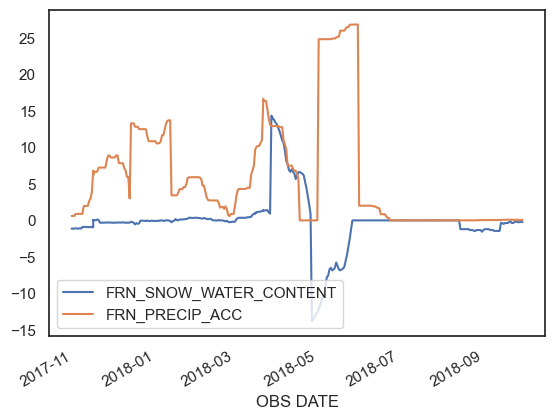

In [82]:
# save
stationary_FRN_PRECIP_ACC_SWE_2017.to_csv('stationary_FRN_PRECIP_ACC_SWE_2017.csv', header=False)

# plot
stationary_FRN_PRECIP_ACC_SWE_2017.plot()
plt.show()

<Axes: xlabel='FRN_SNOW_WATER_CONTENT', ylabel='FRN_PRECIP_ACC'>

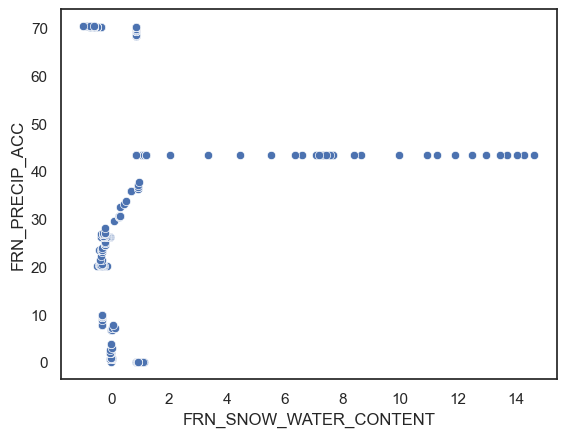

In [83]:
sns.scatterplot(data=FRN_PRECIP_ACC_SWE_WATER_YEAR_2017, x="FRN_SNOW_WATER_CONTENT", y="FRN_PRECIP_ACC") 

<Axes: xlabel='FRN_SNOW_WATER_CONTENT', ylabel='FRN_PRECIP_ACC'>

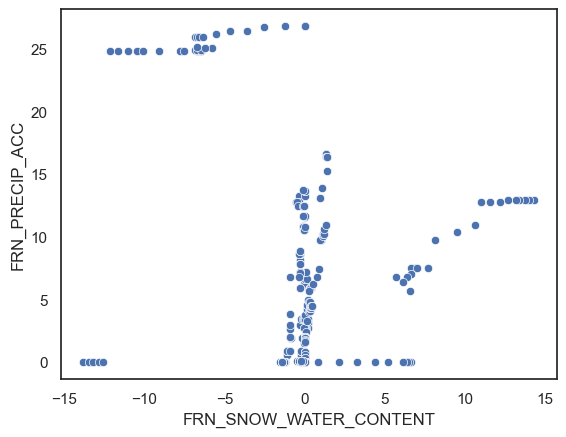

In [84]:
# differenced
sns.scatterplot(data=stationary_FRN_PRECIP_ACC_SWE_2017, x="FRN_SNOW_WATER_CONTENT", y="FRN_PRECIP_ACC")

### Data cleaning

To do (see steps in Notion task as well): 
- Smoothing: 
    - Exponential smoothing for this problem (I think): treat more recent data as more informative data, in which case exponential smoothing is a good option. 
- Handle seasonality --> seasonal data smoothing. See Orielly book. Can be used with exponential moving avg smoothing
- Normalize data

In [ ]:
"""
Smoothing utility function: Exponential moving average

- Uses past 30 periods or days to inform prediction (give them more weight) in order to capture trends
- Span corresponds to what is commonly called an “N-day EW moving average”
- mean() for the average in exponential moving average
"""

def smooth(df):
  # cast value column to int for smoothing
  # df.iloc[:, 0] = df.iloc[:, 0].astype(int)
  return df.ewm(span=30.0, ignore_na=True).mean(engine='numba')

In [ ]:
# Use and remove seasonality: Use differencing. See page 121 in the ML book phone. With code example. 
# Seasonal data smoothing see Orielly book 
# ADD HERE: 


In [ ]:
# Normalizing utility function - prep for training. Last step

# see your Notion notes
# maximum absolute scaling rescales each feature between -1 and 1 by dividing every observation 
# by its maximum absolute value


# ADD HERE: 

